<h1>Linear Regression for Market Returns on Gold</h1>
<p>Alright, the goal is to extract data from the Yahoo Finance API and predict future prices based on that using linear regression. Simple beans.</p>
Keep in mind that when loading the data, set the auto_adjust parameter to True to avoid noise caused by dividends and stock splits.

In [1]:
import yfinance as yf
data = yf.download("GC=F", start="2018-01-01", end = "2025-10-01", auto_adjust = True)
#data = yf.download("TSLA", start="2018-01-01", end="2025-10-01", auto_adjust=True)
#print(data)

[*********************100%***********************]  1 of 1 completed


<h3>Making features.</h3>
- Return is the percentage change of the closing price of Gold for the day.<br>
- MA means Moving Average. MA5 is of 5 days, MA10 is of 10 days. These smooth out the data from the daily noise.<br>
- Momentum measures how much the price has changed over the last 5 days.<br>
- Volatility is the standard deviation of returns. It gives us an idea about risk.<br>
- Target: Is supposed to be next day's return.<br>

In [2]:
data['Return'] = data['Close'].pct_change()
data['MA5'] = data['Close'].rolling(5).mean()
data['MA10'] = data['Close'].rolling(10).mean()
data['Momentum'] = data["Close"]/data["Close"].shift(5) - 1
data["Volatility"] = data ["Return"].rolling(10).std()
data["Target"] = data["Return"].shift(-1)

data = data.dropna()

In [3]:
train = data.iloc[:-250]
test = data.iloc[-250:]
features = ["Return", "MA5", "MA10", "Momentum", "Volatility"]

<h3>Training:</h3>
We'll use simple scikit for this.

In [4]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train[features], train["Target"])
preds = model.predict(test[features])

<h3>Checking Accuracy:</h3>
R^2 Score: Coefficient of determination. R^2 = 1 - (SSE/SS), where SSE = Sum of square of errors and SS = Sum of squares

In [5]:
from sklearn.metrics import r2_score, mean_squared_error
print(r2_score(test["Target"], preds))

-0.00010334972008396726


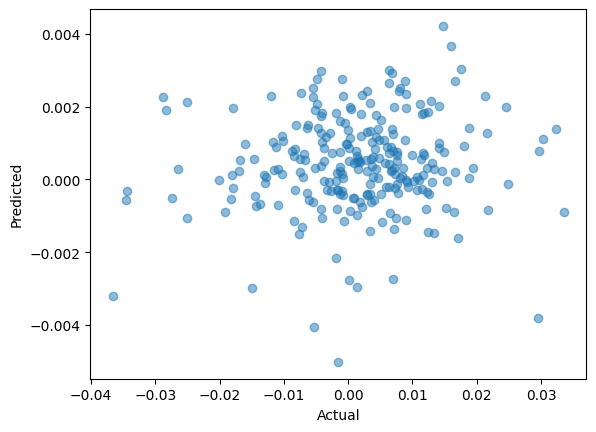

In [6]:
import matplotlib.pyplot as plt
plt.scatter(test["Target"], preds, alpha = .5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

As we can see, this model is ass.<br>
Our Predictions vs Expected values are just a random cloud. Not good.

<h2>Re-Evaluation</h2>
Markets are inherently unpredictable to begin with, so we couldn't have expected models with an R^2 close to 1. However, having a negative score feels like a punch in the jugular. <br>
We'll examine the features we've considered.


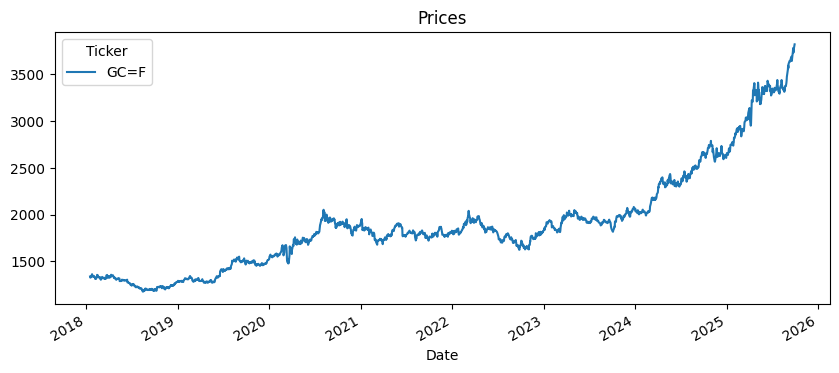

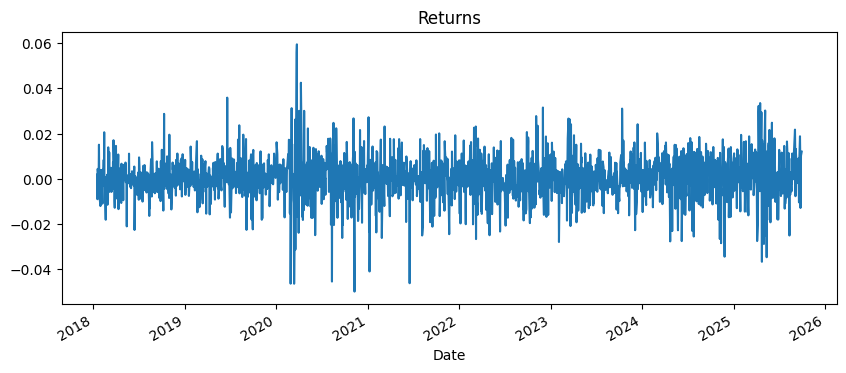

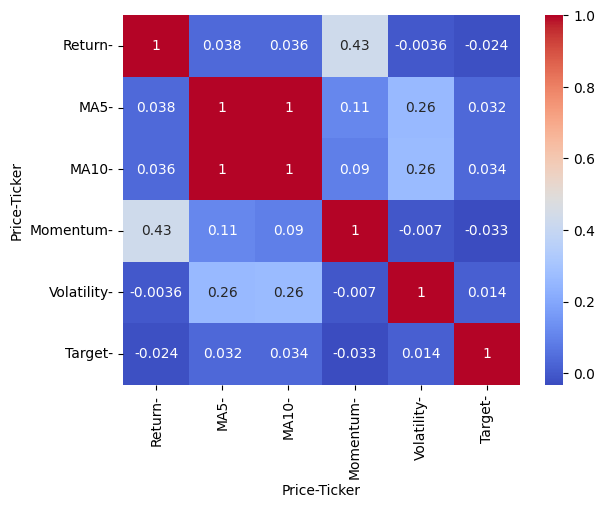

In [7]:
import seaborn as sns

data["Close"].plot(title="Prices", figsize=(10, 4))
plt.show()
data["Return"].plot(title="Returns", figsize=(10, 4))
plt.show()

sns.heatmap(data[["Return", "MA5", "MA10", "Momentum", "Volatility", "Target"]].corr(), annot=True, cmap="coolwarm")
plt.show()                   

In [8]:
#Debugging block
print (len(data))
print (data.columns.tolist())

1937
[('Close', 'GC=F'), ('High', 'GC=F'), ('Low', 'GC=F'), ('Open', 'GC=F'), ('Volume', 'GC=F'), ('Return', ''), ('MA5', ''), ('MA10', ''), ('Momentum', ''), ('Volatility', ''), ('Target', '')]


The main problem lies in the fact that the closing prices vary significantly on a day-by-day basis, making it impossible for the system to be decomposed by regression.

<h1>Logistic Direction Predictor using Time Series and XGB</h1>
This is a more realistic metric which we can expect to find based on the data we're working with. It simply predicts if tomorrow's prices will go up or down.
<ul>
<li> Having MA5 and MA10 was redundant. We'll use MA_Spread = MA5 - MA10
<li> Lagged returns.
<li> Volatility over 5 days and 10 days
<li> Volume change percentage.
</ul>

In [9]:
import numpy as np

print (len(data))
for i in range(1, 6):
    data[f'return_lag_{i}'] = data['Return'].shift(i)

data['MA20'] = data['Close'].rolling(20).mean()
data['MA_spread'] = data['MA5'] - data['MA20']

data['vol_ma5'] = data['Return'].rolling(5).std()
data['vol_ma10'] = data['Return'].rolling(10).std()

data['volume_change'] = data['Volume'].pct_change()

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()

print(len(data))

1937
1884


In [10]:
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor

features = [c for c in data.columns if c[0].startswith('return_lag_')]
features += [('MA_spread', ''), ('Momentum', ''), ('vol_ma5', ''), ('vol_ma10', ''), ('volume_change', '')]

X = data[features]
y = data['Target']

train = data.iloc[:-250]
test = data.iloc[-250:]

model = XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.05)
model.fit(train[features], train['Target'])
preds = model.predict(test[features])

In [11]:
mse = mean_squared_error(test['Target'], preds)
direction_acc = np.mean(np.sign(preds) == np.sign(test['Target']))
print("MSE:", mse, "Direction acc:", direction_acc)

MSE: 0.00014164144790454567 Direction acc: 0.472


In [12]:
tscv = TimeSeriesSplit(n_splits=5)
scores = []
for train_idx, val_idx in tscv.split(X):
    model = XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.05)
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    p = model.predict(X.iloc[val_idx])
    scores.append(np.mean(np.sign(p) == np.sign(y.iloc[val_idx])))
print("CV directional accuracies:", scores, "mean:", np.mean(scores))

CV directional accuracies: [0.4840764331210191, 0.5127388535031847, 0.49044585987261147, 0.5286624203821656, 0.5095541401273885] mean: 0.5050955414012739


We have near 50% accuracy, which is marginally better than betting, but... ig it's something for a week 1 project.